In [44]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, Conv2D, Flatten, Dense, Reshape
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import backend as K
from keras import initializers
import keras

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

from skimage.measure import block_reduce

In [2]:
brief_patch_size = 48  # default value of PATCH_SIZE in OpenCV implementation
input_patch_size = 56  # larger than the default value, s.t. the blurring is done using valid padding

nb_epoch = 50
batch_size = 32

averaging_kernel_weight_9x9 = 1./81
averaging_kernel_weight_5x5 = 1./25
averaging_kernel_weight_3x3 = 1./9

weights_dense = np.load("./weights/weights_dense_64.npy")

In [3]:
base_dir = '/scratch/image_datasets/2_for_learned_brief/ridiculously_small'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

train_descrs_dir      = base_dir + '/train'
validation_descrs_dir = base_dir + '/validation'
test_descrs_dir       = base_dir + '/test'

In [47]:
def loading_data(dir_patches, dir_descrs):
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches_in = []
    patches_out = []

    
    for file_patch in files_patches:
        patch_in = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patch_out = patch_in[5: 53, 5: 53]
        patch_out = block_reduce(patch_out, (8, 8), func=np.mean)
        
        patches_in.append(patch_in)
        patches_out.append(patch_out)
        

    patches_in = np.array(patches_in)
    patches_in = patches_in.astype(np.float64) / 255
    
    patches_out = np.array(patches_out)
    patches_out = patches_out.astype(np.float64) / 255
    
    print("in", patches_in.shape, "  out", patches_out.shape)
    
    return patches_in, patches_out

In [48]:
x_train, y_train = loading_data(train_data_dir, train_descrs_dir)
x_validation, y_validation = loading_data(validation_data_dir, validation_descrs_dir)

in (504, 56, 56)   out (504, 6, 6)
in (63, 56, 56)   out (63, 6, 6)


In [49]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))

x_validation = x_validation.reshape((x_validation.shape[0], x_validation.shape[1], x_validation.shape[2], 1))
y_validation = y_validation.reshape((y_validation.shape[0], y_validation.shape[1], y_validation.shape[2], 1))
print(x_train.shape, y_train.shape)
print(x_validation.shape, y_validation.shape)

(504, 56, 56, 1) (504, 6, 6, 1)
(63, 56, 56, 1) (63, 6, 6, 1)


In [7]:
def fixed_generator(x_train, y_train, batch_size):
    while True:
        batch_list_x = []
        batch_list_y = []
        
        for i in range(x_train.shape[0]):
            batch_list_x.append(x_train[i])
            batch_list_y.append(y_train[i])
            if len(batch_list_x) == batch_size:
                yield (np.array(batch_list_x),np.array(batch_list_y))
                batch_list_x = []
                batch_list_y = []

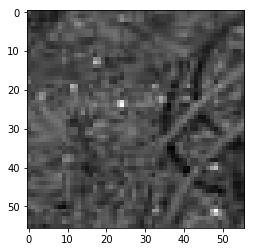

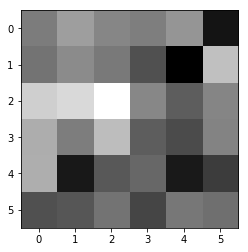

In [61]:
plt.imshow(x_train[3, :, :, 0], cmap='gray')
plt.show()
plt.imshow(y_train[3, :, :, 0], cmap='gray')
plt.show()

In [85]:
input_shape = (input_patch_size, input_patch_size, 1)
input_img = Input(shape=input_shape)

x = Conv2D(1, (3,3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros(), trainable=False)(input_img)
x = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros(), trainable=False)(x)
x = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros(), trainable=False)(x)
average_blurred = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros(), trainable=False)(x)
flattened = Flatten(data_format="channels_last")(average_blurred)
briefed = Dense(weights_dense.shape[1], activation="sigmoid", weights=[weights_dense, np.zeros(weights_dense.shape[1])], trainable=False)(flattened)

# INSERT CODE HERE
x = Dense(1152, activation="relu")(briefed)
x = Reshape((6, 6, 32))(x)

x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(8, (3,3), activation="relu", padding="same")(x)
decoded = Conv2D(1, (3,3), activation="sigmoid", padding="same")(x)

# x = UpSampling2D((2, 2))(x)



brief_ae = Model(input_img, decoded)

brief_ae.compile(optimizer=my_adadelta, loss="binary_crossentropy")
brief_ae.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 56, 56, 1)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 54, 54, 1)         10        
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 52, 52, 1)         10        
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 50, 50, 1)         10        
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 48, 48, 1)         10        
_________________________________________________________________
flatten_7 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               1180

In [80]:
from keras.callbacks import Callback
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        decay = self.model.optimizer.decay
        iterations = self.model.optimizer.iterations
        lr_with_decay = lr / (1. + decay * K.cast(iterations, K.dtype(decay)))
        print(K.eval(lr_with_decay))
        
lr_print = MyCallback()

In [84]:
my_adadelta = keras.optimizers.Adadelta(learning_rate=0.8, rho=0.95)

In [87]:
model_version = '0.0.0.2.2_decoder_dense1152_conv32_conv32_conv8_conv1__relu_last_sigmoid_bce_lr0.8'

os.system('mkdir ' + base_dir + '/weights' + model_version)

checkpointer = keras.callbacks.ModelCheckpoint(
    base_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',
    verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

brief_ae.fit_generator(fixed_generator(x_train, y_train, batch_size),
                steps_per_epoch=x_train.shape[0],
                epochs=200,
                validation_data=fixed_generator(x_validation, y_validation, batch_size),
                validation_steps=x_validation.shape[0],
                callbacks=[lr_print]
                )

brief_ae.save(base_dir + '/brief_ae_' + model_version + '.h5')


Epoch 1/200
504/504 [==============================] - 11s 22ms/step - loss: 0.6774 - val_loss: 0.6641
0.8
Epoch 2/200
504/504 [==============================] - 11s 21ms/step - loss: 0.6736 - val_loss: 0.6589
0.8
Epoch 3/200
504/504 [==============================] - 11s 21ms/step - loss: 0.6704 - val_loss: 0.6614
0.8
Epoch 4/200
504/504 [==============================] - 11s 22ms/step - loss: 0.6678 - val_loss: 0.6563
0.8
Epoch 5/200
504/504 [==============================] - 11s 21ms/step - loss: 0.6660 - val_loss: 0.6540
0.8
Epoch 6/200
504/504 [==============================] - 11s 21ms/step - loss: 0.6644 - val_loss: 0.6557
0.8
Epoch 7/200
504/504 [==============================] - 11s 21ms/step - loss: 0.6631 - val_loss: 0.6516
0.8
Epoch 8/200
504/504 [==============================] - 11s 21ms/step - loss: 0.6620 - val_loss: 0.6528
0.8
Epoch 9/200
504/504 [==============================] - 11s 21ms/step - loss: 0.6608 - val_loss: 0.6588
0.8
Epoch 10/200
504/504 [===============

0.8
Epoch 77/200
504/504 [==============================] - 11s 21ms/step - loss: 0.6252 - val_loss: 0.6858
0.8
Epoch 78/200
504/504 [==============================] - 11s 21ms/step - loss: 0.6244 - val_loss: 0.6831
0.8
Epoch 79/200
504/504 [==============================] - 11s 22ms/step - loss: 0.6239 - val_loss: 0.6962
0.8
Epoch 80/200
504/504 [==============================] - 11s 22ms/step - loss: 0.6248 - val_loss: 0.6876
0.8
Epoch 81/200
504/504 [==============================] - 11s 21ms/step - loss: 0.6238 - val_loss: 0.6704
0.8
Epoch 82/200
504/504 [==============================] - 11s 21ms/step - loss: 0.6241 - val_loss: 0.6828
0.8
Epoch 83/200
504/504 [==============================] - 11s 21ms/step - loss: 0.6236 - val_loss: 0.6741
0.8
Epoch 84/200
504/504 [==============================] - 11s 21ms/step - loss: 0.6231 - val_loss: 0.6929
0.8
Epoch 85/200
504/504 [==============================] - 11s 22ms/step - loss: 0.6235 - val_loss: 0.6768
0.8
Epoch 86/200
504/504 [==

In [88]:
model_version = '0.0.0.2.2_decoder_dense1152_conv32_conv32_conv8_conv1__relu_last_sigmoid_bce_lr0.8_trainmore'

os.system('mkdir ' + base_dir + '/weights' + model_version)

checkpointer = keras.callbacks.ModelCheckpoint(
    base_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',
    verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

brief_ae.fit_generator(fixed_generator(x_train, y_train, batch_size),
                steps_per_epoch=x_train.shape[0],
                epochs=800,
                validation_data=fixed_generator(x_validation, y_validation, batch_size),
                validation_steps=x_validation.shape[0],
                callbacks=[lr_print]
                )

brief_ae.save(base_dir + '/brief_ae_' + model_version + '.h5')


Epoch 1/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6112 - val_loss: 0.6701
0.8
Epoch 2/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6114 - val_loss: 0.6784
0.8
Epoch 3/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6108 - val_loss: 0.6869
0.8
Epoch 4/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6105 - val_loss: 0.6788
0.8
Epoch 5/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6108 - val_loss: 0.6817
0.8
Epoch 6/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6105 - val_loss: 0.6703
0.8
Epoch 7/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6108 - val_loss: 0.6746
0.8
Epoch 8/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6106 - val_loss: 0.6864
0.8
Epoch 9/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6102 - val_loss: 0.6782
0.8
Epoch 10/800
504/504 [===============

0.8
Epoch 77/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6075 - val_loss: 0.6694
0.8
Epoch 78/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6066 - val_loss: 0.6902
0.8
Epoch 79/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6071 - val_loss: 0.6738
0.8
Epoch 80/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6072 - val_loss: 0.6788
0.8
Epoch 81/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6068 - val_loss: 0.6663
0.8
Epoch 82/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6070 - val_loss: 0.6635
0.8
Epoch 83/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6069 - val_loss: 0.6723
0.8
Epoch 84/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6071 - val_loss: 0.6666
0.8
Epoch 85/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6070 - val_loss: 0.6735
0.8
Epoch 86/800
504/504 [==

504/504 [==============================] - 11s 22ms/step - loss: 0.6040 - val_loss: 0.6733
0.8
Epoch 228/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6041 - val_loss: 0.6843
0.8
Epoch 229/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6036 - val_loss: 0.6765
0.8
Epoch 230/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6035 - val_loss: 0.6859
0.8
Epoch 231/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6035 - val_loss: 0.6787
0.8
Epoch 232/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6035 - val_loss: 0.6758
0.8
Epoch 233/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6034 - val_loss: 0.6926
0.8
Epoch 234/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6037 - val_loss: 0.6809
0.8
Epoch 235/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6033 - val_loss: 0.6779
0.8
Epoch 236/800
504/504 [==========

504/504 [==============================] - 11s 22ms/step - loss: 0.6027 - val_loss: 0.6795
0.8
Epoch 378/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6025 - val_loss: 0.6801
0.8
Epoch 379/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6021 - val_loss: 0.6812
0.8
Epoch 380/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6019 - val_loss: 0.6811
0.8
Epoch 381/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6019 - val_loss: 0.6852
0.8
Epoch 382/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6022 - val_loss: 0.6798
0.8
Epoch 383/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6016 - val_loss: 0.6887
0.8
Epoch 384/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6021 - val_loss: 0.6826
0.8
Epoch 385/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6021 - val_loss: 0.6745
0.8
Epoch 386/800
504/504 [==========

504/504 [==============================] - 11s 22ms/step - loss: 0.6003 - val_loss: 0.6742
0.8
Epoch 528/800
504/504 [==============================] - 11s 22ms/step - loss: 0.5998 - val_loss: 0.6806
0.8
Epoch 529/800
504/504 [==============================] - 11s 22ms/step - loss: 0.5999 - val_loss: 0.6808
0.8
Epoch 530/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6001 - val_loss: 0.6917
0.8
Epoch 531/800
504/504 [==============================] - 11s 22ms/step - loss: 0.5996 - val_loss: 0.6832
0.8
Epoch 532/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6005 - val_loss: 0.6808
0.8
Epoch 533/800
504/504 [==============================] - 11s 22ms/step - loss: 0.5995 - val_loss: 0.6800
0.8
Epoch 534/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6000 - val_loss: 0.6821
0.8
Epoch 535/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6004 - val_loss: 0.6769
0.8
Epoch 536/800
504/504 [==========

504/504 [==============================] - 11s 22ms/step - loss: 0.5997 - val_loss: 0.6771
0.8
Epoch 678/800
504/504 [==============================] - 11s 22ms/step - loss: 0.5995 - val_loss: 0.6795
0.8
Epoch 679/800
504/504 [==============================] - 11s 22ms/step - loss: 0.6000 - val_loss: 0.6781
0.8
Epoch 680/800
504/504 [==============================] - 11s 22ms/step - loss: 0.5992 - val_loss: 0.6785
0.8
Epoch 681/800
504/504 [==============================] - 11s 22ms/step - loss: 0.5997 - val_loss: 0.6774
0.8
Epoch 682/800
504/504 [==============================] - 11s 22ms/step - loss: 0.5991 - val_loss: 0.6772
0.8
Epoch 683/800
504/504 [==============================] - 11s 22ms/step - loss: 0.5991 - val_loss: 0.6784
0.8
Epoch 684/800
504/504 [==============================] - 11s 22ms/step - loss: 0.5993 - val_loss: 0.6757
0.8
Epoch 685/800
504/504 [==============================] - 11s 22ms/step - loss: 0.5992 - val_loss: 0.6776
0.8
Epoch 686/800
504/504 [==========

predictions: 


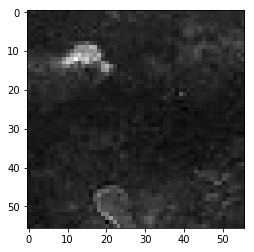

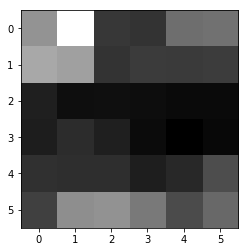

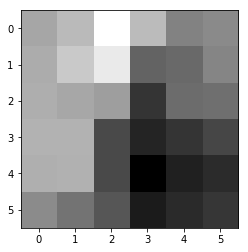

next


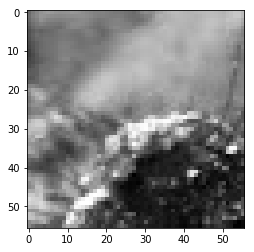

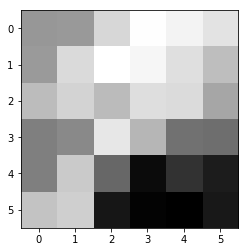

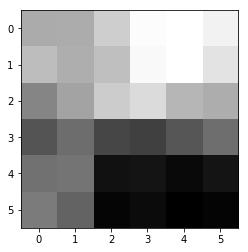

next


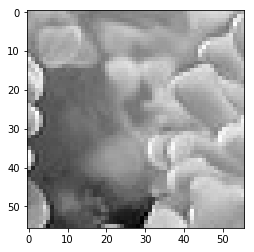

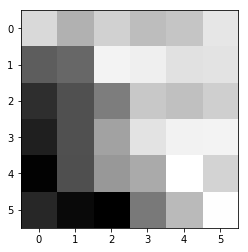

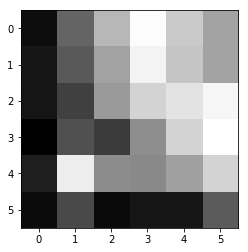

next


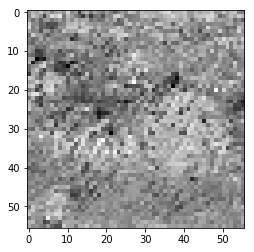

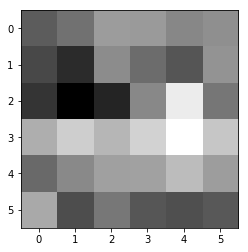

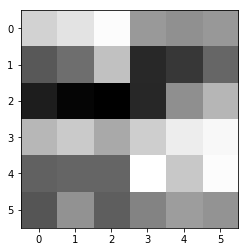

next


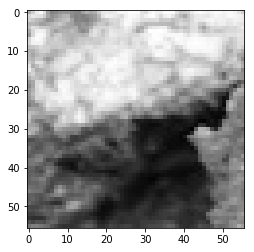

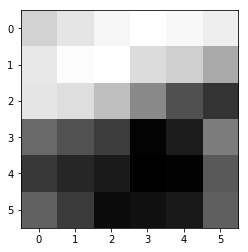

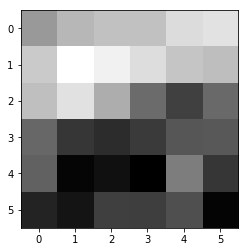

next


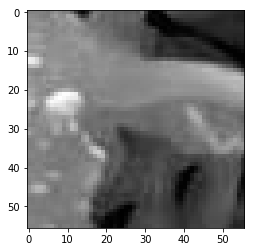

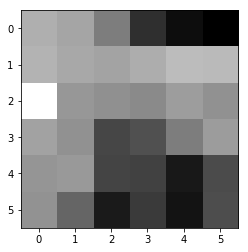

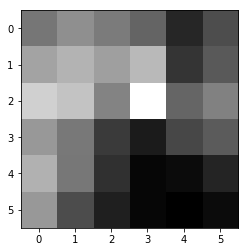

next


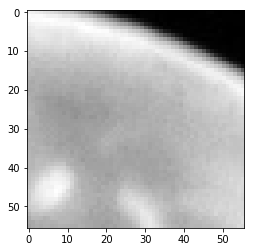

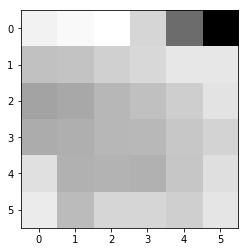

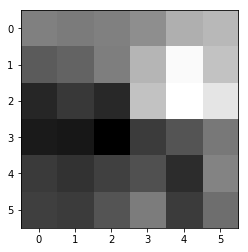

next


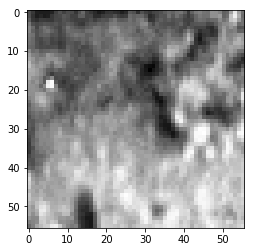

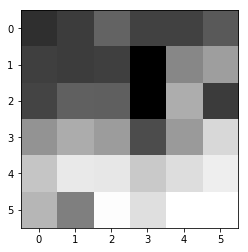

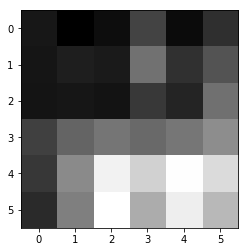

next


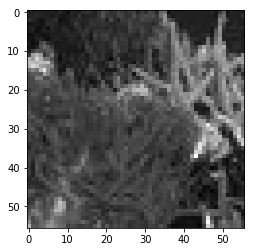

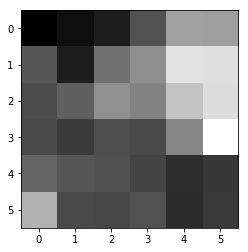

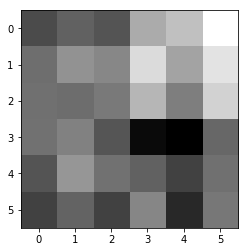

next


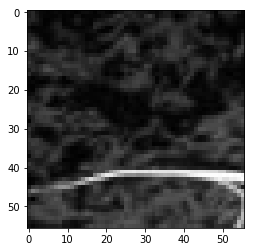

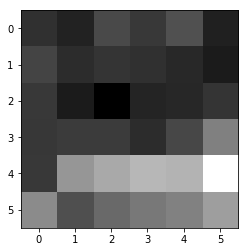

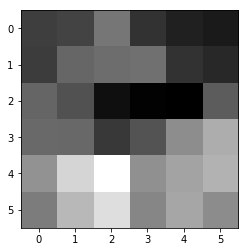

next


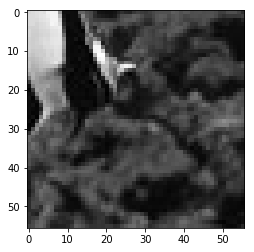

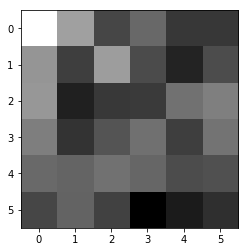

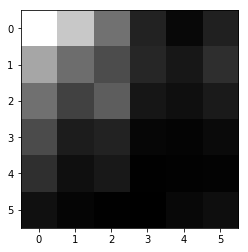

next


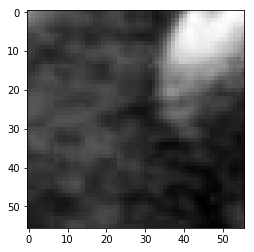

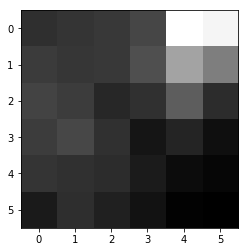

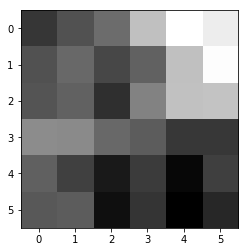

next


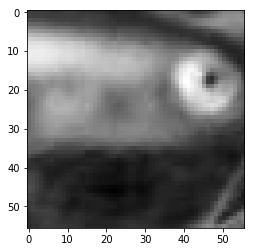

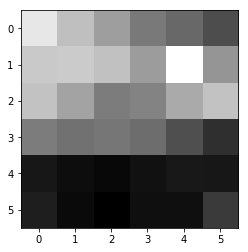

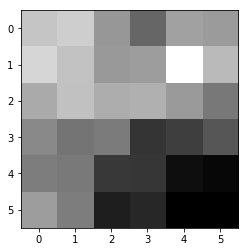

next


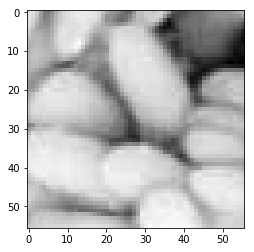

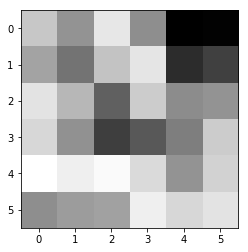

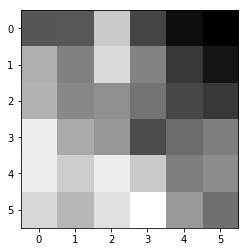

next


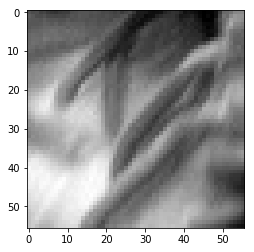

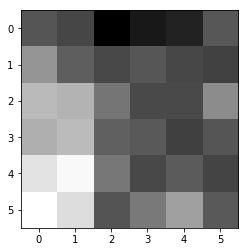

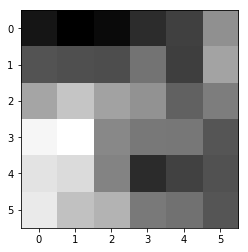

next


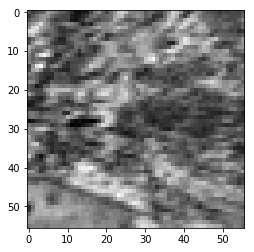

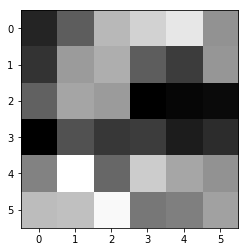

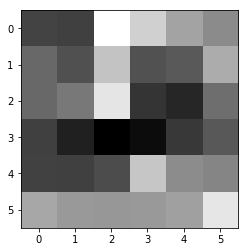

next


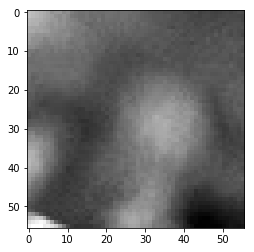

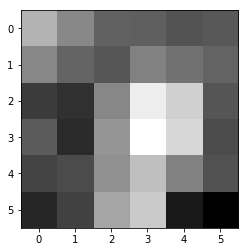

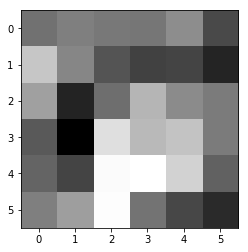

next


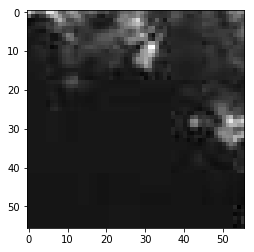

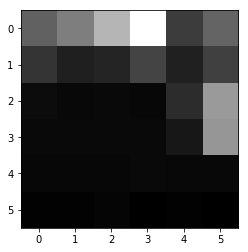

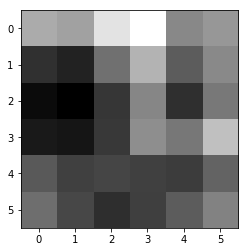

next


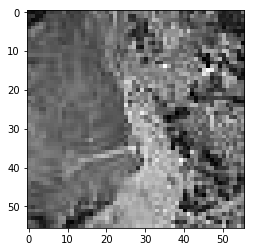

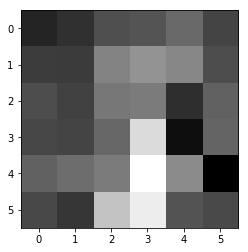

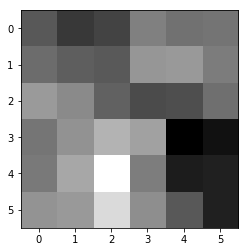

next


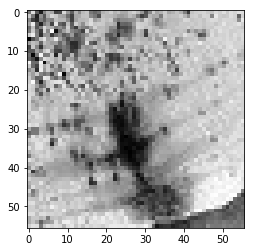

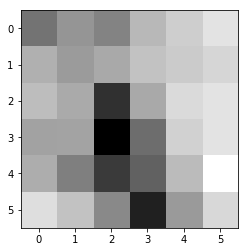

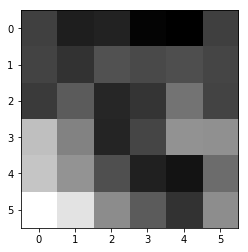

next


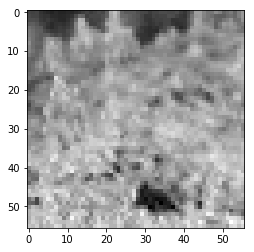

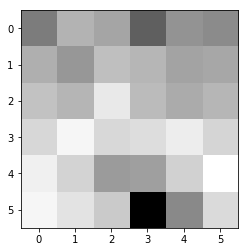

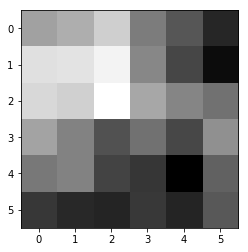

next


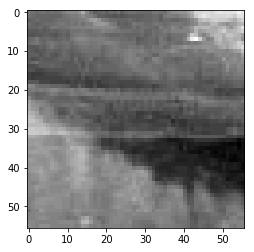

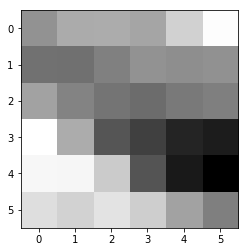

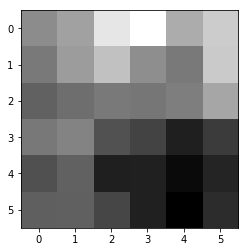

next


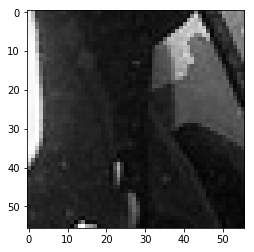

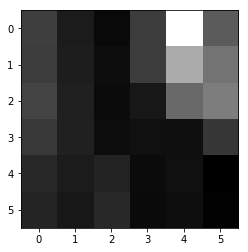

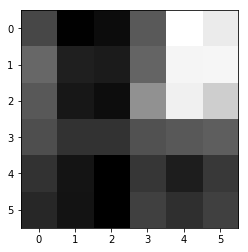

next


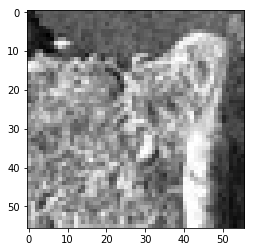

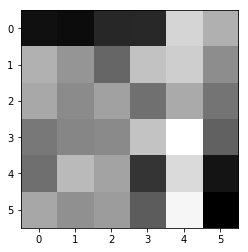

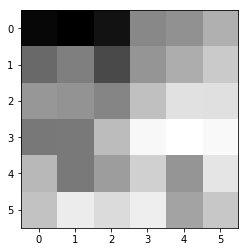

next


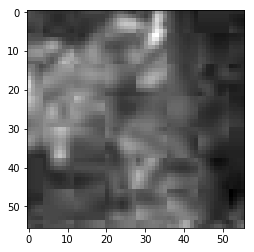

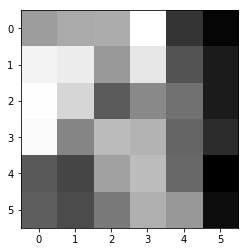

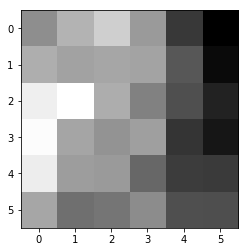

next


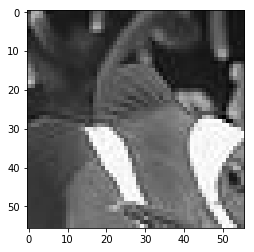

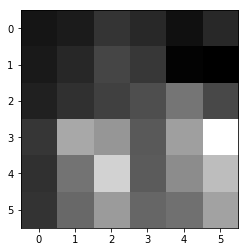

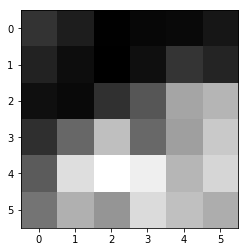

next


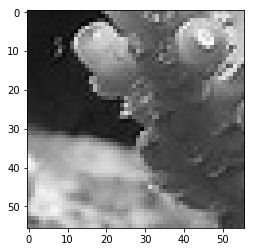

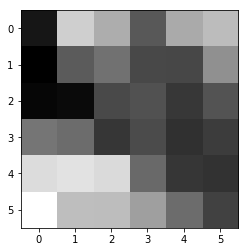

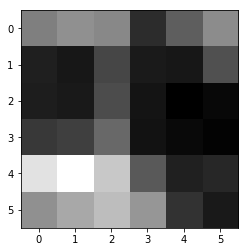

next


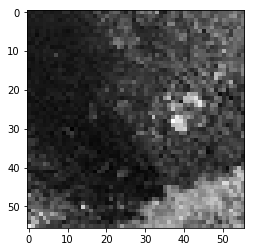

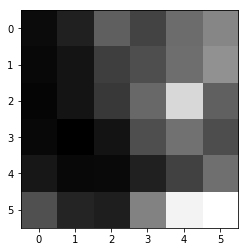

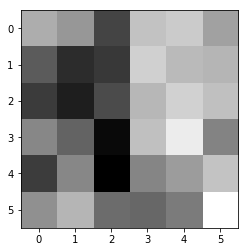

next


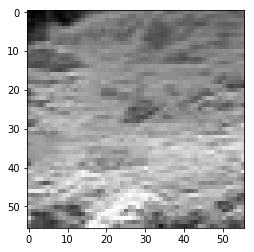

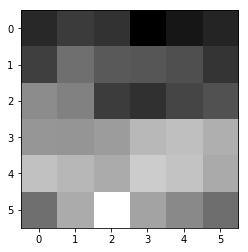

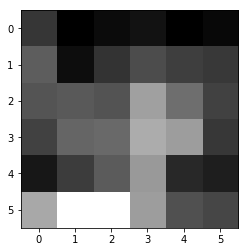

next


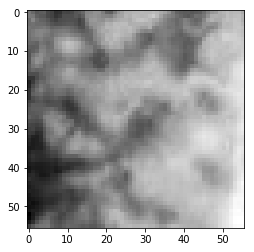

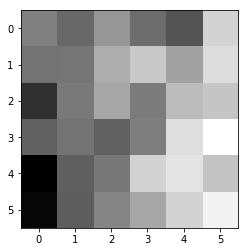

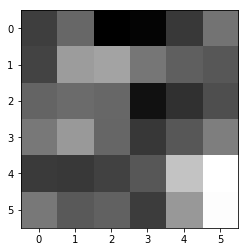

next


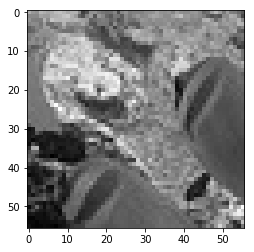

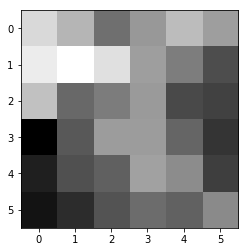

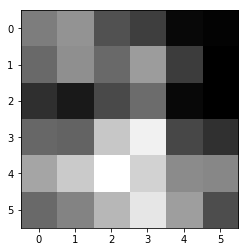

next


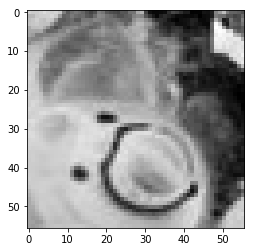

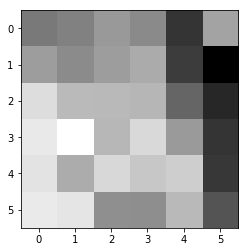

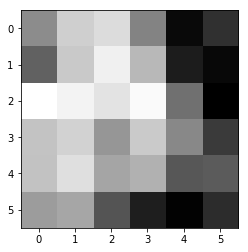

next


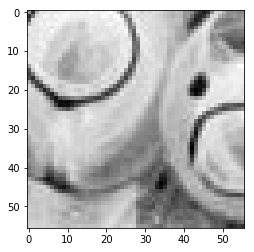

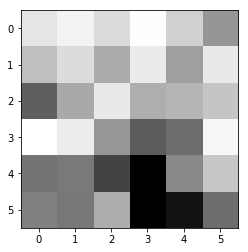

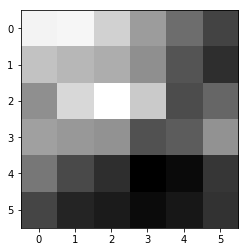

next


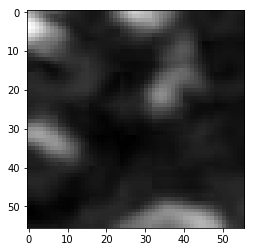

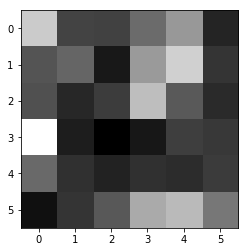

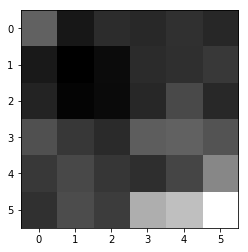

next


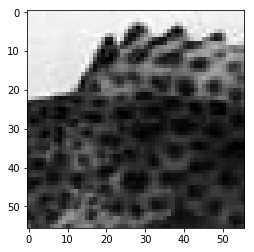

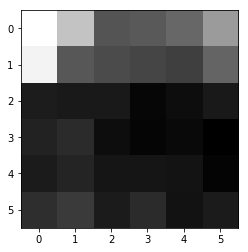

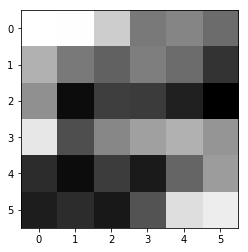

next


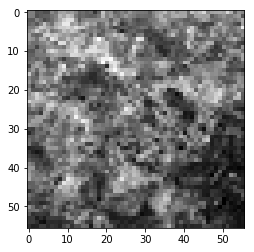

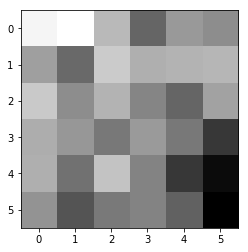

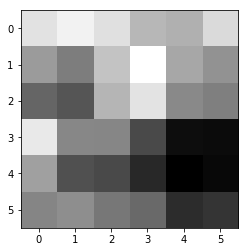

next


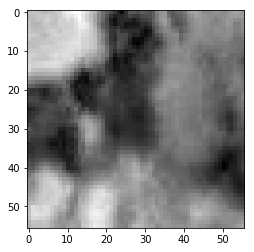

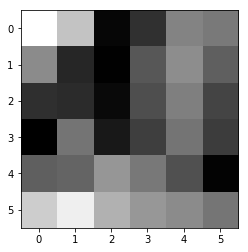

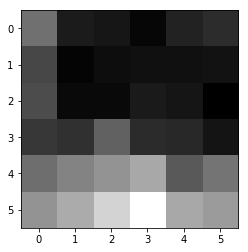

next


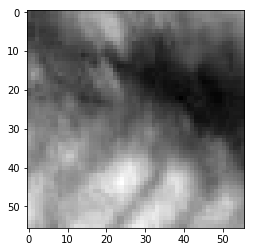

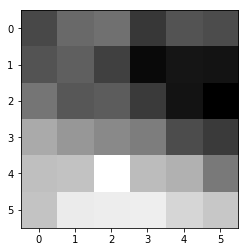

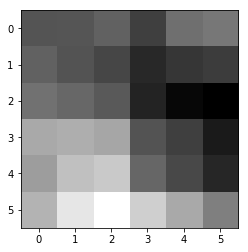

next


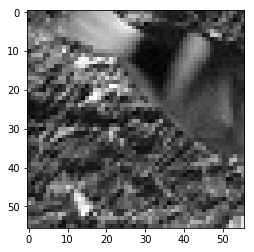

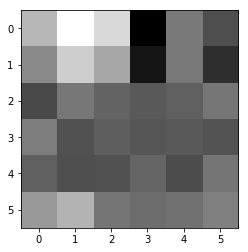

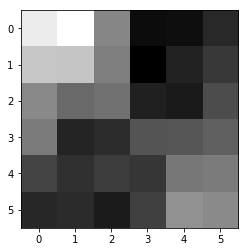

next


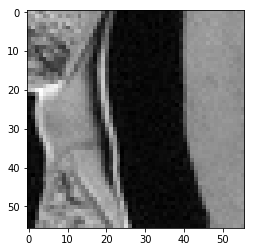

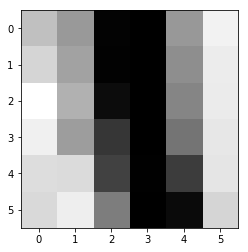

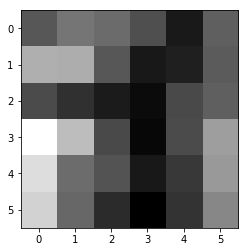

next


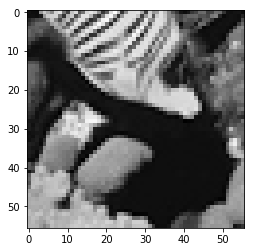

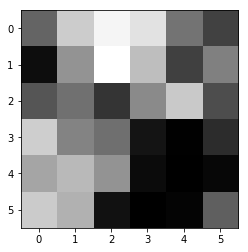

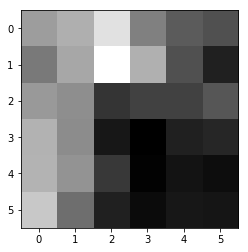

next


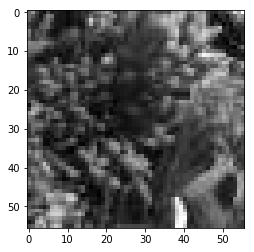

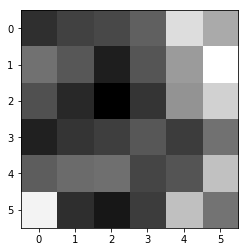

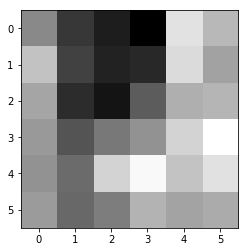

next


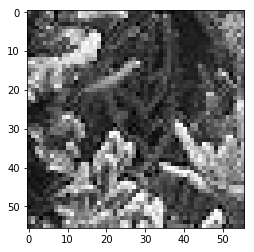

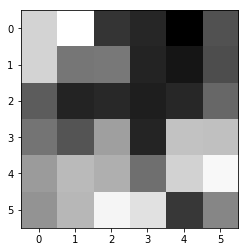

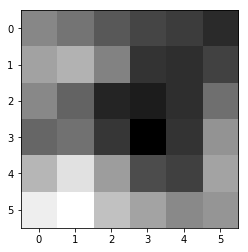

next


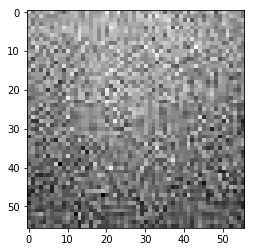

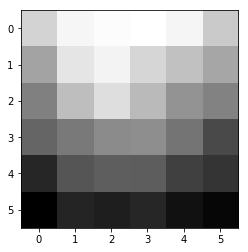

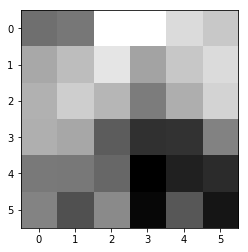

next


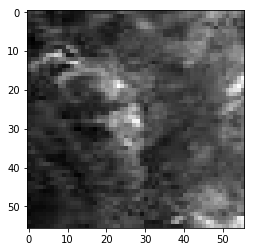

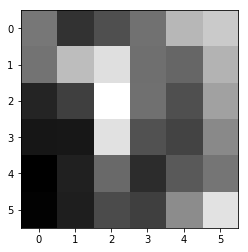

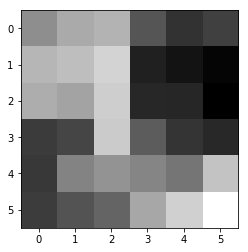

next


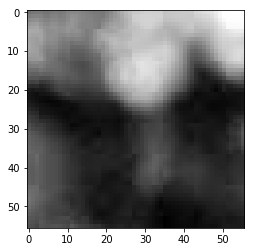

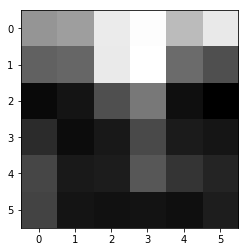

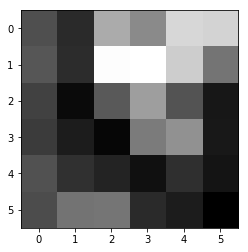

next


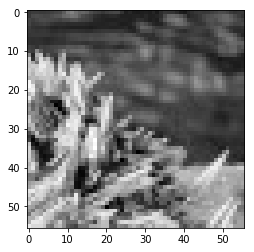

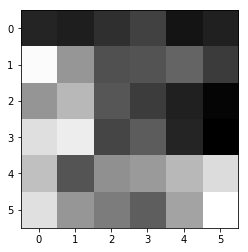

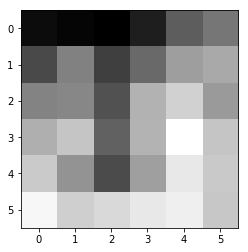

next


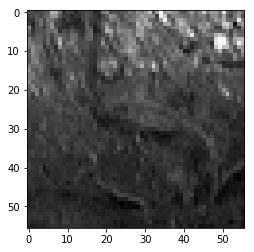

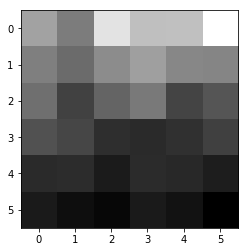

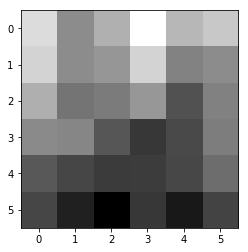

next


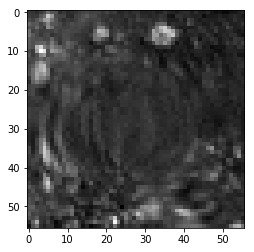

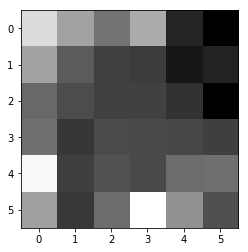

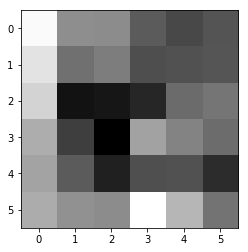

next


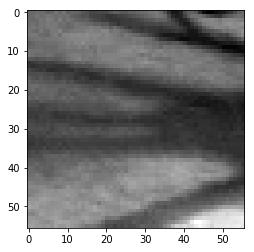

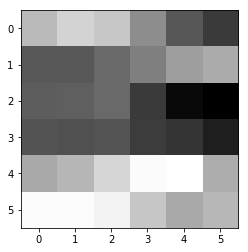

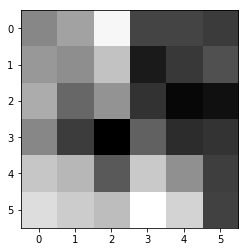

next


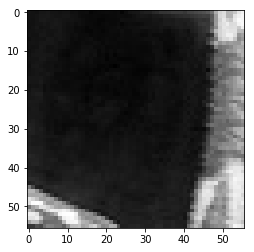

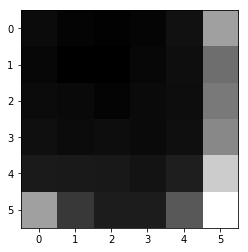

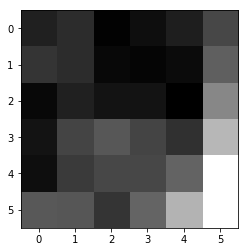

next


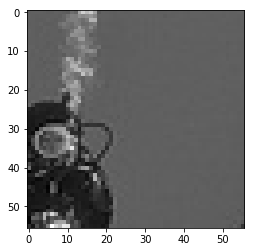

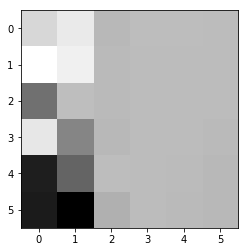

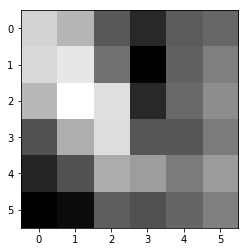

next


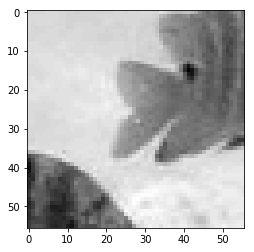

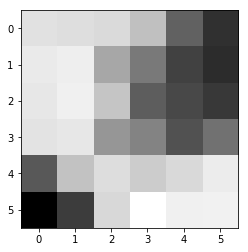

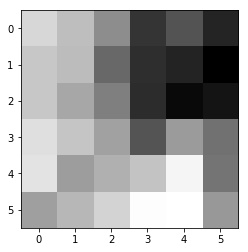

next


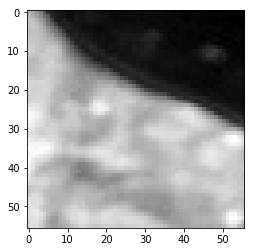

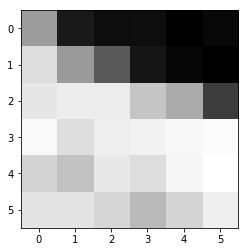

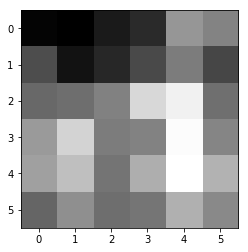

next


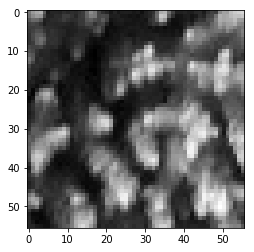

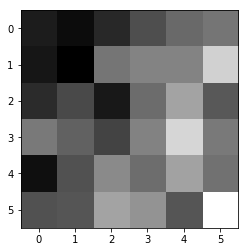

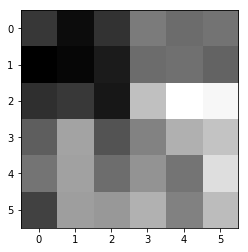

next


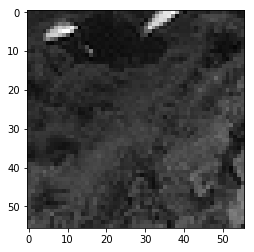

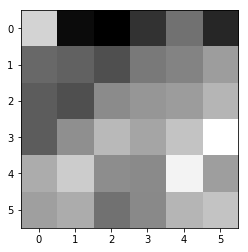

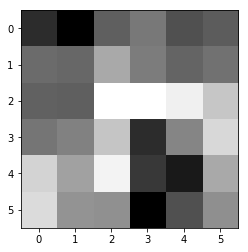

next


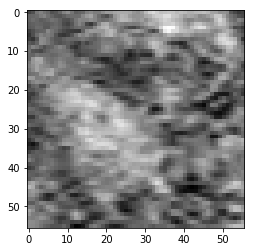

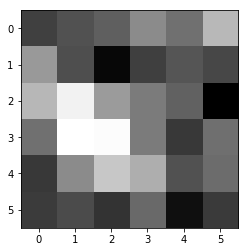

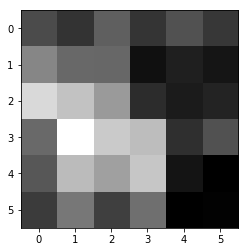

next


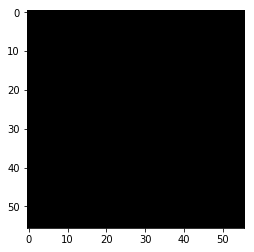

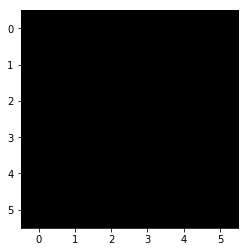

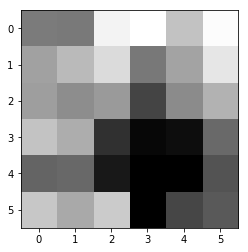

next


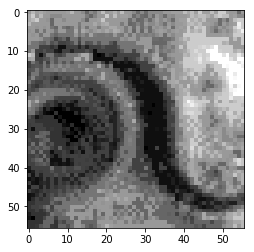

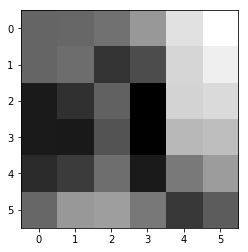

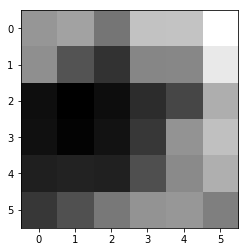

next


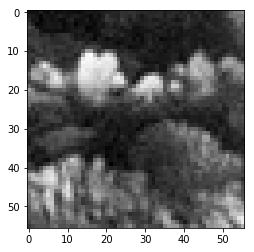

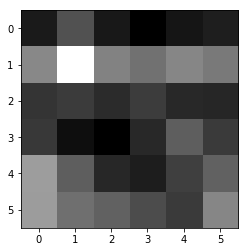

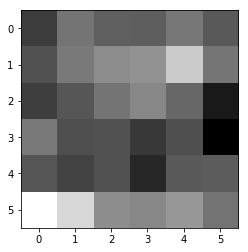

next


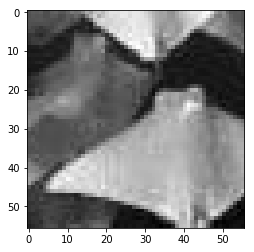

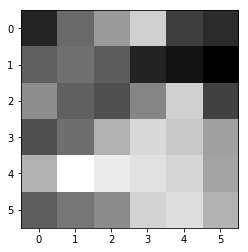

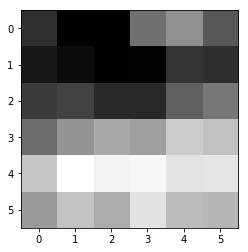

next


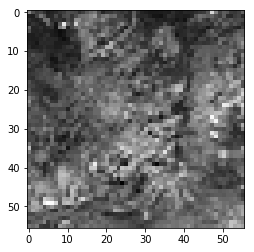

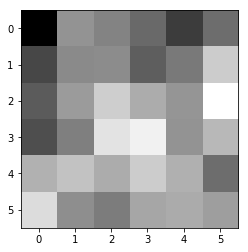

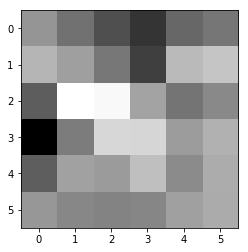

next


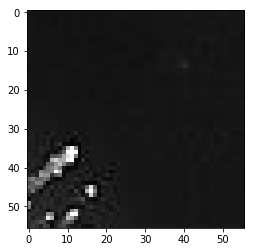

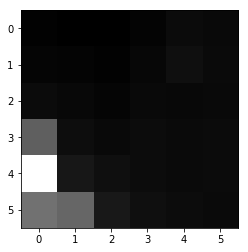

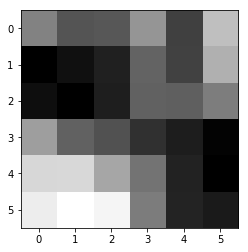

next


In [92]:
images_directory = base_dir + '/test/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(input_patch_size, input_patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        


images = np.array(images).reshape(np.array(images).shape[0], input_shape[0], input_shape[1], input_shape[2])
images = images / 255
predictions = brief_ae.predict_on_batch(np.array(images))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape(input_shape)
    plt.imshow(im_1[:, :, 0], cmap='gray')
    plt.show()
    
    
    
    ground_truth = im_1[5: 53, 5: 53, 0]
    ground_truth = block_reduce(ground_truth, (8, 8), func=np.mean)
    plt.imshow(ground_truth[:, :], cmap='gray')
    plt.show()
    
    
    pred_1 = predictions[i].reshape((6, 6))
    plt.imshow(pred_1, cmap='gray')
    plt.show()
    
    print("next")